## Forecast energy consumption

**Usecase** <br>
Forecast energy consumption when we are given hourly energy usage, temperature, and humidity information 

**Refrences**<br>
1. [Feature Tranformation for cyclic features](https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f) <br>
2. [Tensorflow time series forecast](https://www.tensorflow.org/tutorials/structured_data/time_series)

**Process**<br>
The notebook contains the following sections
1. Data analysis
2. ML models: Single step models, and Multi step models
3. Performance analysis
4. Residual analysis

In [1]:
#Data structures
import pandas as pd
import numpy as np
import datetime as dt

#plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#Statistics
import math
import scipy as sp
from sklearn import preprocessing, metrics
#Forecasting
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

import IPython
import IPython.display

In [2]:
mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

### Data analysis

**Understanding the data**

The customer time series data has the following properties
1. Hourly frequency
2. 351 days of hourly data
3. Features: [Energy consumption, Temperature, Humidity]

**Cleaning the data**

In this section we "clean" the following aspects of data

1. [Experiment with and without] Remove 9am Monday data (weird behavior: we see a dip at this time)
2. Fill in missing elements with last known value

**Feature engineering** <br>

1. [Experiment a and b] Encoding time <br>
    1.a Use sine and cosine to capture the cyclic nature of hour of the day, day of the week, time of the year <br>
    1.b Use one hot encoding to capture weekday and hour of the day <br>

#### Capture prior knowledge about data

In [4]:
data_frequency_pandas_str = '1h'
data_frequency_num_points = 24

#### Load and visualize data

In [5]:
datapath='../data/IoTData.csv'
timestampcolumn = 'DATETIME'
df = pd.read_csv(datapath, index_col=False, parse_dates=[timestampcolumn])

<AxesSubplot:title={'center':'Last 24 days of hourly data'}, xlabel='DATETIME', ylabel='KW'>

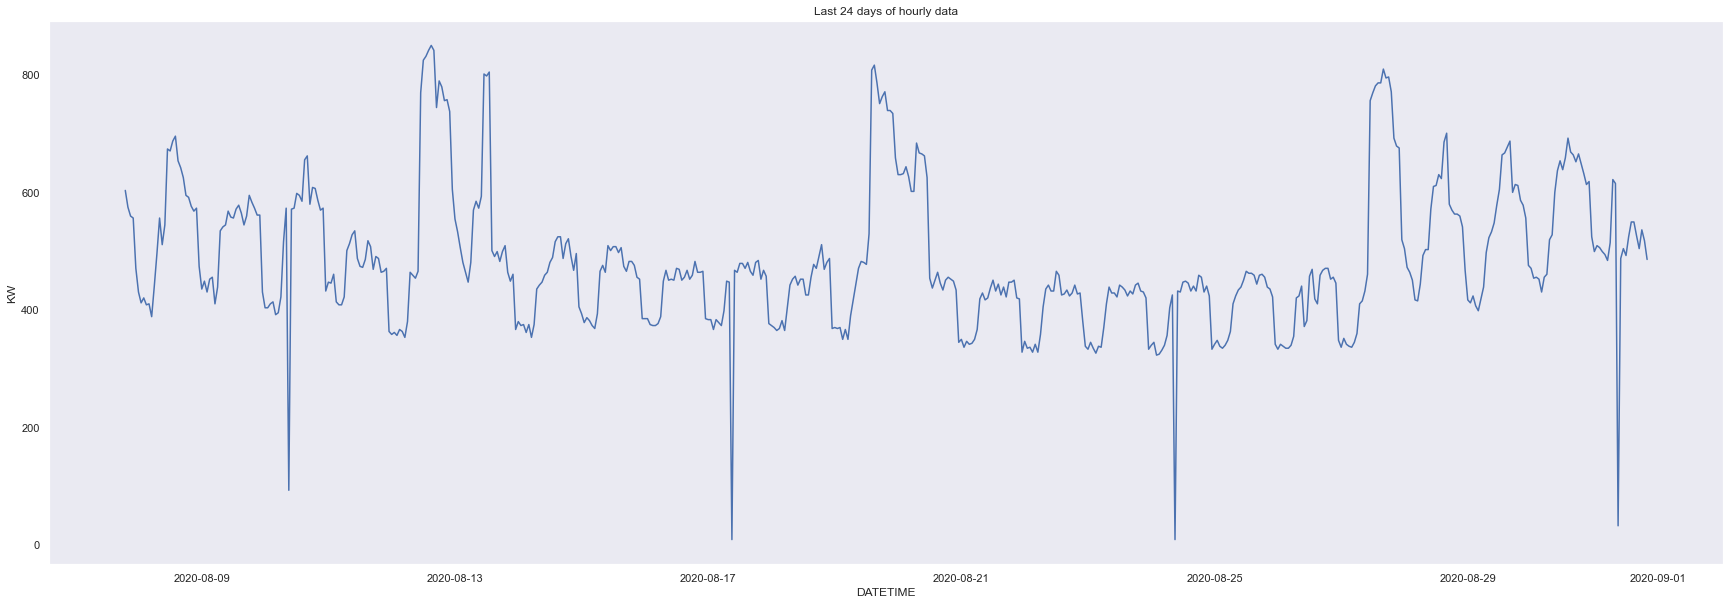

In [6]:
plot_size = (30, 10)
fig, ax = plt.subplots(figsize=plot_size)
plt.title("Last 24 days of hourly data")
sns.lineplot(x='DATETIME', y='KW', data=df[-24*24:])

In [ ]:
# run this cell to remove Monday 9AM
def monday_9_am(row, col_name=timestampcolumn):
    if row[col_name].weekday() == 0 and row[col_name].hour == 9:
        return np.nan
    else:
        return True

#removes monday 9 am data
df.loc[:, ('not_monday_9_am')] = df.apply(lambda row: monday_9_am(row), axis=1)
df = df.dropna()
df.drop(columns=['not_monday_9_am'], inplace=True)

Let's take a glance at the data. Here are the first few rows:

In [7]:
df.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80.0,690.48,69.05
1,2019-09-15 01:00:00,18.2,83.0,685.44,68.54
2,2019-09-15 02:00:00,18.2,83.0,656.88,65.69
3,2019-09-15 03:00:00,18.2,83.0,655.20,65.52
4,2019-09-15 04:00:00,18.3,82.0,660.24,66.02


In [8]:
df.drop(columns=['KW2', 'UMIDADE_REL'], inplace=True)

Plot the evolution of some features over time

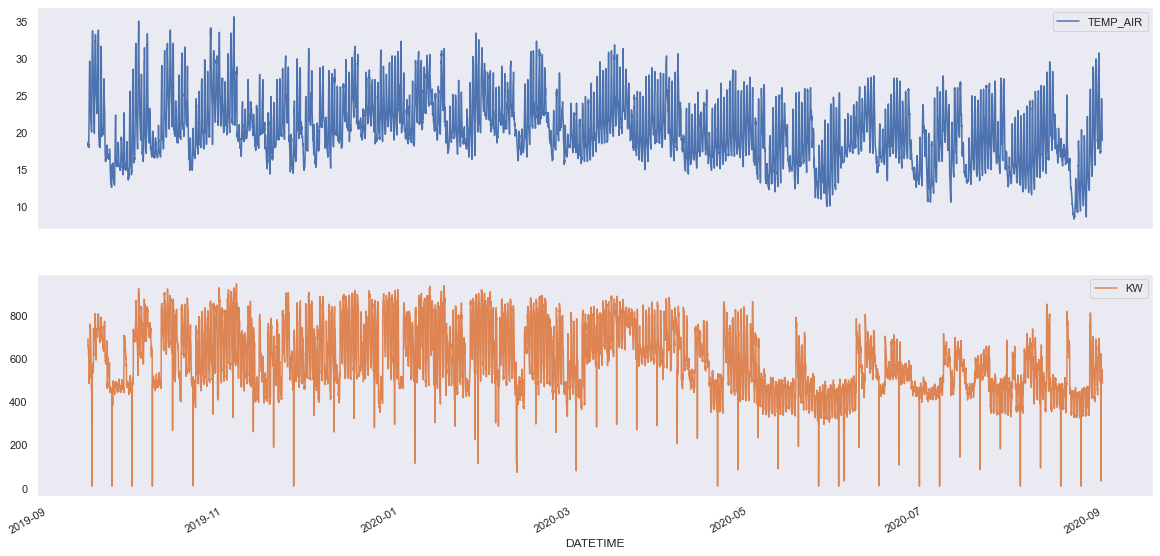

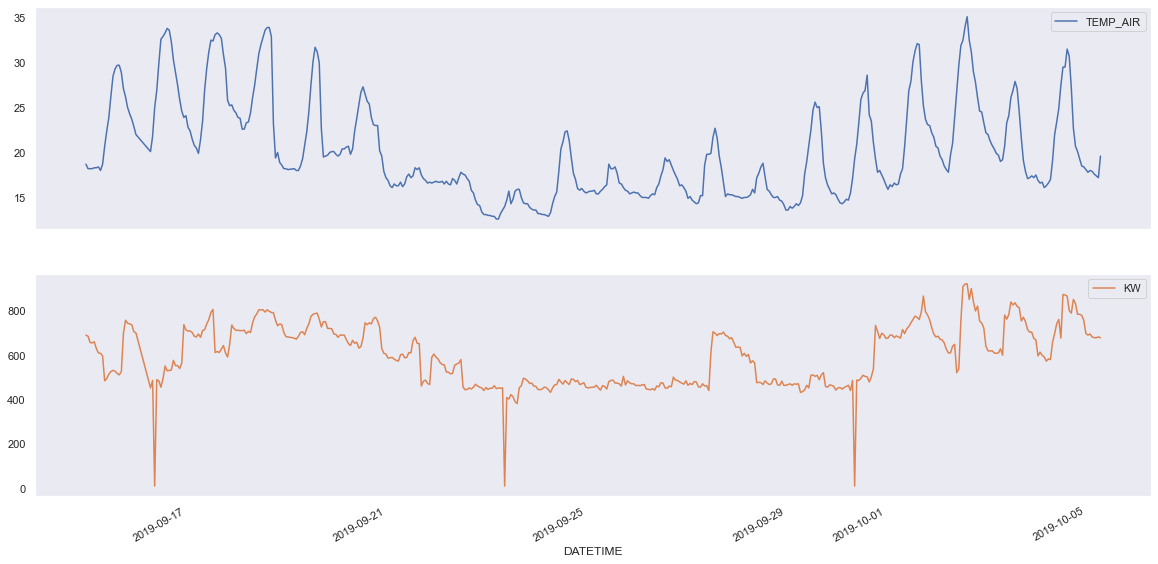

In [9]:
plot_cols = ['TEMP_AIR', 'KW']
plot_features = df[plot_cols]
plot_features.index = df.DATETIME
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df.DATETIME[:480]
_ = plot_features.plot(subplots=True)

#### Data inspection and cleanup

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TEMP_AIR,8336.0,20.43,4.37,8.3,17.4,20.10,23.10,35.70
KW,8336.0,587.67,154.29,8.4,470.4,557.76,703.92,944.16


Fill in missing elements for a constant frequency

In [11]:
df_freq = df.copy()
df_freq.index = df_freq.DATETIME
df_freq.pop('DATETIME')
df_freq = df_freq.asfreq(freq=data_frequency_pandas_str)
date_time = df_freq.index

In [12]:
# fill in missing data with the last known value
df_freq = df_freq.ffill()

In [13]:
df_freq.head()

,TEMP_AIR,KW
DATETIME,,
2019-09-15 00:00:00,18.7,690.48
2019-09-15 01:00:00,18.2,685.44
2019-09-15 02:00:00,18.2,656.88
2019-09-15 03:00:00,18.2,655.20
2019-09-15 04:00:00,18.3,660.24


In [14]:
df_freq.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TEMP_AIR,8445.0,20.41,4.35,8.3,17.4,20.10,23.10,35.70
KW,8445.0,587.12,154.14,8.4,470.4,557.76,702.24,944.16


#### Feature Engineering

Being weather data, it has clear daily and yearly periodicity (as seen in the fft below)


2021-11-30 13:23:23.708340: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


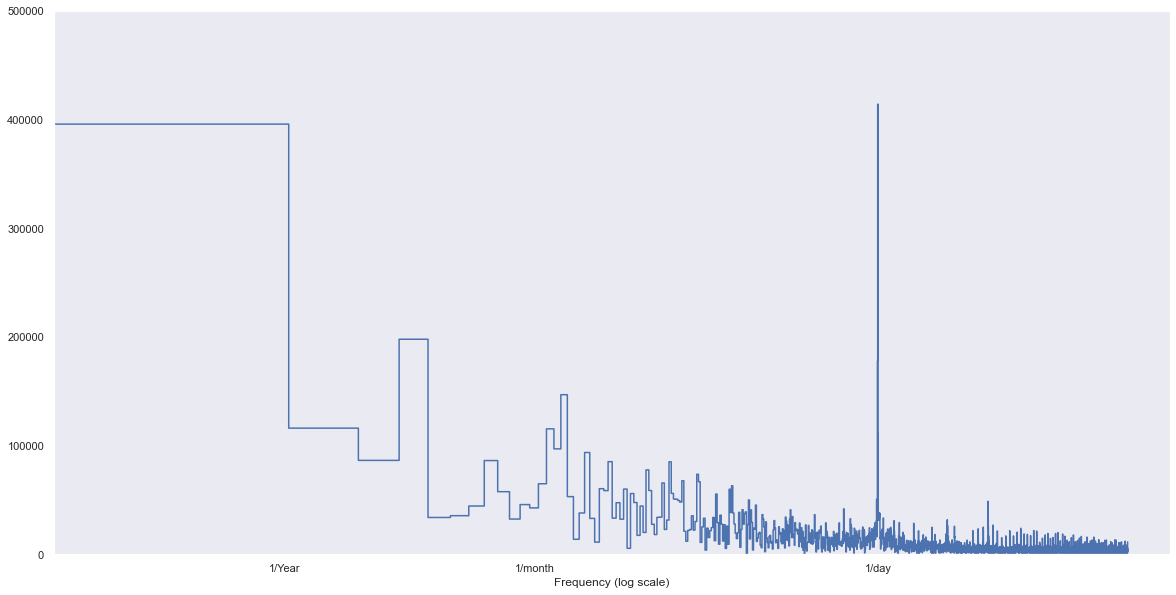

In [15]:
fft = tf.signal.rfft(df_freq['KW'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_freq['KW'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 500000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 12, 365.2524], labels=['1/Year', '1/month', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [16]:
# Summarize data 
f"We have data for {max(df_freq.index.date) - min(df_freq.index.date)} days"

'We have data for 351 days, 0:00:00 days'

Convert datetime to seconds

In [17]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

[Experiment 1.a] Use sine and cosine transorms to capture features related to time 

In [18]:
day = 24*60*60 # number of seconds in a day
week = (7)*day # number of seconds in a week
year = (365.2425)*day # number of seconds in a year

df_freq['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_freq['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_freq['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df_freq['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
# df_freq['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df_freq['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

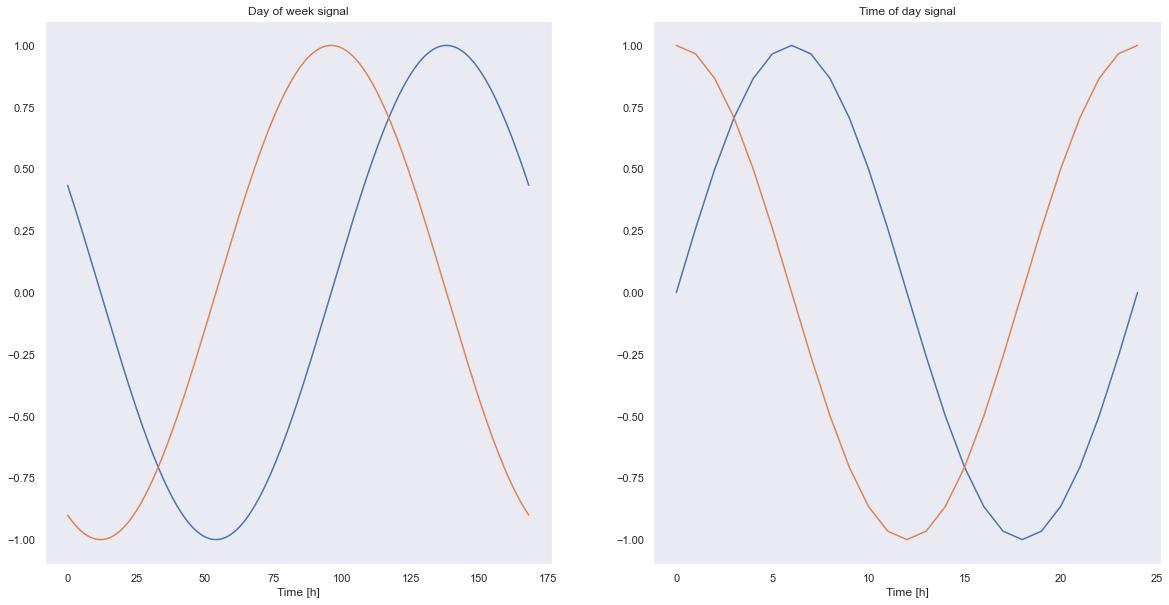

In [19]:
# using the variable axs for multiple Axes
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(np.array(df_freq['Week sin'])[:24*7+1])
ax1.plot(np.array(df_freq['Week cos'])[:24*7+1])
ax1.set_xlabel('Time [h]')
ax1.set_title('Day of week signal')

ax2.plot(np.array(df_freq['Day sin'])[:25])
ax2.plot(np.array(df_freq['Day cos'])[:25])
ax2.set_xlabel('Time [h]')
ax2.set_title('Time of day signal')

[Experiment 1.b] One hot encode the time features

why are we shifting hour up 

In [ ]:
n = int(len(df_freq)*0.7)
df_freq.loc[:, ('hour_of_day')] = date_time.hour
df_freq['hour_of_day'] = df_freq['hour_of_day'].shift(-24)

df_freq.loc[:, ('day_of_week')] = date_time.weekday
df_freq['day_of_week'] = df_freq['day_of_week'].shift(-24)

df_freq = df_freq.dropna()

# 1. one hot encode hour of day
hour_categories = [f'hour_{n}' for n in range(24)]
enc_hour = preprocessing.OneHotEncoder()
enc_hour.fit(df_freq['hour_of_day'].values[:n].reshape(-1,1))
a = enc_hour.transform(df_freq['hour_of_day'].values.reshape(-1,1)).toarray()
df_hour = pd.DataFrame(data=a,columns=hour_categories)
df_hour.index = df_freq.index
df_freq.pop('hour_of_day')

# 2. one hot encode day of week
weekday_categories = [f'weekday_{n}' for n in range(7)]
enc = preprocessing.OneHotEncoder()
enc.fit(df_freq['day_of_week'].values[:n].reshape(-1,1))
a = enc.transform(df_freq['day_of_week'].values.reshape(-1,1)).toarray()
df_weekday = pd.DataFrame(data=a,columns=weekday_categories)
df_weekday.index = df_freq.index
df_freq.pop('day_of_week')


df_freq = pd.concat([df_freq,df_hour,df_weekday], axis=1)

In [20]:
df_freq.head()

,TEMP_AIR,KW,Day sin,Day cos,Week sin,Week cos
DATETIME,,,,,,
2019-09-15 00:00:00,18.7,690.48,-6.25e-12,1.00,0.43,-0.90
2019-09-15 01:00:00,18.2,685.44,2.59e-01,0.97,0.40,-0.92
2019-09-15 02:00:00,18.2,656.88,5.00e-01,0.87,0.37,-0.93
2019-09-15 03:00:00,18.2,655.20,7.07e-01,0.71,0.33,-0.94
2019-09-15 04:00:00,18.3,660.24,8.66e-01,0.50,0.29,-0.96


#### Split the data

Use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [21]:
column_indices = {name: i for i, name in enumerate(df_freq.columns)}

n = len(df_freq)
train_df = df_freq[0:int(n*0.7)]
val_df = df_freq[int(n*0.7):int(n*0.9)]
test_df = df_freq[int(n*0.9):]

num_features = df_freq.shape[1]

In [22]:
train_df.head()

,TEMP_AIR,KW,Day sin,Day cos,Week sin,Week cos
DATETIME,,,,,,
2019-09-15 00:00:00,18.7,690.48,-6.25e-12,1.00,0.43,-0.90
2019-09-15 01:00:00,18.2,685.44,2.59e-01,0.97,0.40,-0.92
2019-09-15 02:00:00,18.2,656.88,5.00e-01,0.87,0.37,-0.93
2019-09-15 03:00:00,18.2,655.20,7.07e-01,0.71,0.33,-0.94
2019-09-15 04:00:00,18.3,660.24,8.66e-01,0.50,0.29,-0.96


#### Normalize the data

It important to scale features before training a NN (weights and loss). When normalizing we use the mean of training data so that we don't have access to any values in validation and test sets during training

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

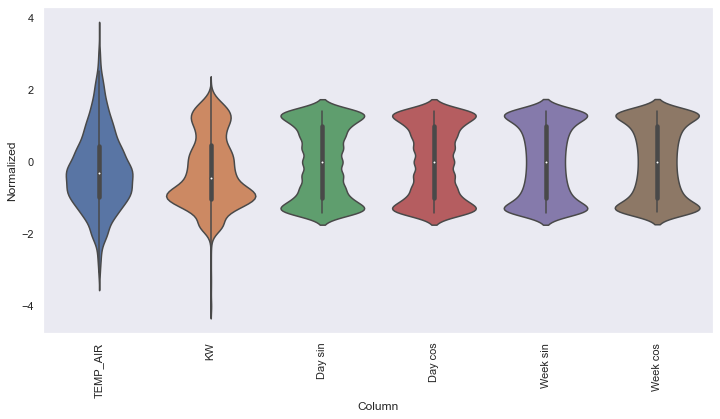

In [24]:
df_std = (df_freq - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_freq.keys(), rotation=90)

In [25]:
train_df.head()

,TEMP_AIR,KW,Day sin,Day cos,Week sin,Week cos
DATETIME,,,,,,
2019-09-15 00:00:00,-0.65,0.41,-1.03e-03,1.41,0.62,-1.26
2019-09-15 01:00:00,-0.77,0.37,3.65e-01,1.36,0.57,-1.29
2019-09-15 02:00:00,-0.77,0.19,7.06e-01,1.22,0.52,-1.31
2019-09-15 03:00:00,-0.77,0.18,9.99e-01,1.00,0.47,-1.33
2019-09-15 04:00:00,-0.75,0.21,1.22e+00,0.71,0.42,-1.34


#### Exploratory Data Analysis

<AxesSubplot:>

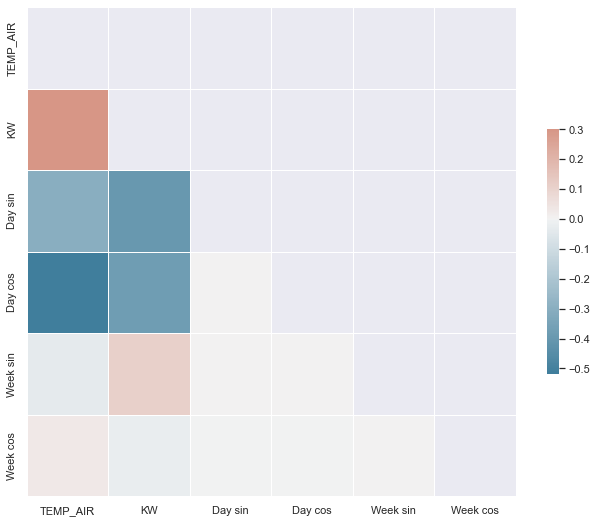

In [26]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Data Windowing

Make predictions based on consecutive samples. Consider
1. the length of the input window and lables
2. offset between input window and labels
3. features used as input, output 


In [27]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [28]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes  
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

WindowGenerator.split_window = split_window

In [29]:
def plot(self, model=None, plot_col='KW', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
        
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
            
        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [148]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [149]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### ML Models

#### Training setup

Forecast 24 hours into the future using both single-step and multi-step models. Single step models use the current time to forecast 24 hours into the future and lack context of how the datapoints around are changing. This context is introduced by using multi-step models where we use a window of data as input

All models use
1. MeanSquaredError loss
2. Adam Optimizer
3. MeanAbsoluteError performance metric

In [150]:
forecast_days = 1

In [151]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

### Single-step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (determined by SHIFT) into the future based only on the current conditions

In [152]:
LABEL_WIDTH = 1
INPUT_WIDTH = 1
SHIFT = forecast_days*data_frequency_num_points
single_step_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                     label_columns=['KW'])
single_step_window

Total window size: 25
Input indices: [0]
Label indices: [24]
Label column name(s): ['KW']

In [153]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=24,
    label_columns=['KW'])

wide_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['KW']

In [154]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [155]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [156]:
val_performance = {}
performance = {}

#### Model 1: Baseline

Predicts the value one SHIFT ago. In our case the baseline forecasts the value now as the value 24 hours into the future

In [157]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

53/53 [==============================] - 0s 827us/step - loss: 0.3106 - mean_absolute_error: 0.3367


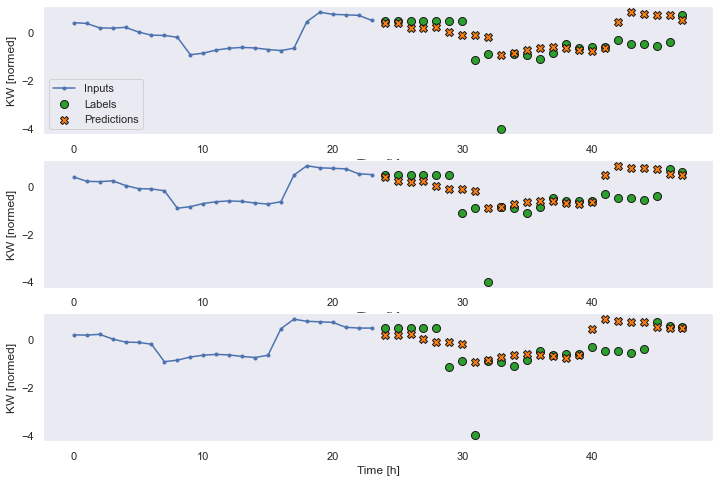

In [158]:
baseline = Baseline(label_index=column_indices['KW'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
wide_window.plot(baseline)

We are plotting 24 hours of windowed data as input. The predictions plot is a shifted input plot shifted by 24 datapoints. This is because the "Baseline" models current prediction = the input energy consumption 24 hours ago 

#### Model 2: Linear 

Here the model will capture a linear relation between "energy consumption now" and "energy consumption, temperature, humidity, and hour of the day 24 hours ago"

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)
Epoch 1/100
184/184 [==============================] - 1s 2ms/step - loss: 1.8978 - mean_absolute_error: 1.1234 - val_loss: 2.0391 - val_mean_absolute_error: 1.1666
Epoch 2/100
184/184 [==============================] - 0s 2ms/step - loss: 1.2975 - mean_absolute_error: 0.9262 - val_loss: 1.4090 - val_mean_absolute_error: 0.9710
Epoch 3/100
184/184 [==============================] - 0s 2ms/step - loss: 0.9380 - mean_absolute_error: 0.7817 - val_loss: 1.0164 - val_mean_absolute_error: 0.8240
Epoch 4/100
184/184 [==============================] - 0s 2ms/step - loss: 0.7281 - mean_absolute_error: 0.6820 - val_loss: 0.7787 - val_mean_absolute_error: 0.7196
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6107 - mean_absolute_error: 0.6190 - val_loss: 0.6380 - val_mean_absolute_error: 0.6482
Epoch 6/100
184/184 [==============================] - 0s 2ms/step - loss: 0.5480 - mean_absolute_error: 0.5814 - val_loss: 0.

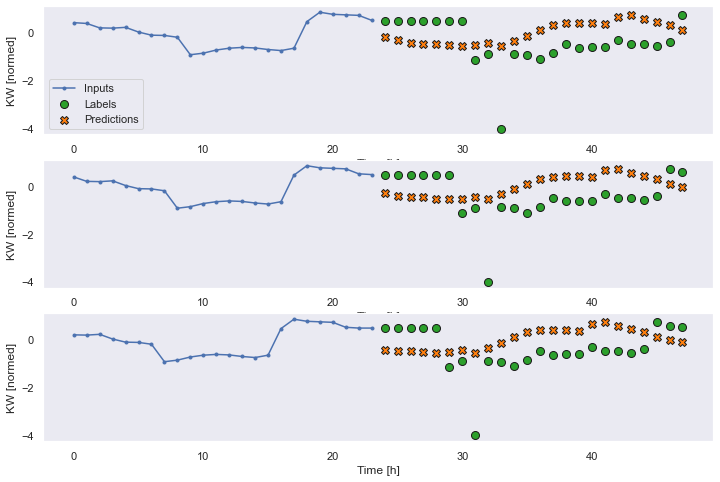

In [159]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
wide_window.plot(linear)

The input data is the same as the baseline model. The linear model is capturing the general trend of the data as it was 24 hours ago

In a linear model we can visualize the weight assigned to each input

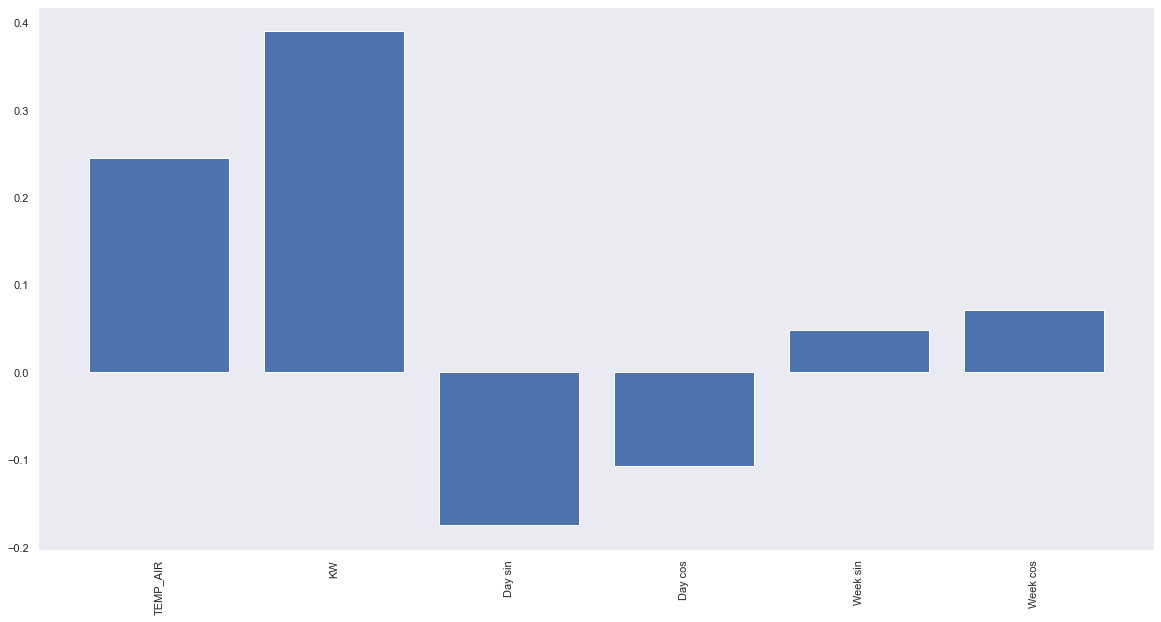

In [160]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Model 3: Dense

Epoch 1/100
184/184 [==============================] - 1s 2ms/step - loss: 0.5743 - mean_absolute_error: 0.5934 - val_loss: 0.3625 - val_mean_absolute_error: 0.4733
Epoch 2/100
184/184 [==============================] - 0s 2ms/step - loss: 0.5082 - mean_absolute_error: 0.5509 - val_loss: 0.3226 - val_mean_absolute_error: 0.4365
Epoch 3/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4946 - mean_absolute_error: 0.5409 - val_loss: 0.3102 - val_mean_absolute_error: 0.4232
Epoch 4/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4872 - mean_absolute_error: 0.5355 - val_loss: 0.3070 - val_mean_absolute_error: 0.4189
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4816 - mean_absolute_error: 0.5313 - val_loss: 0.3063 - val_mean_absolute_error: 0.4174
Epoch 6/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4776 - mean_absolute_error: 0.5284 - val_loss: 0.3068 - val_mean_absolute_error: 0.4173
Epoch 7/10

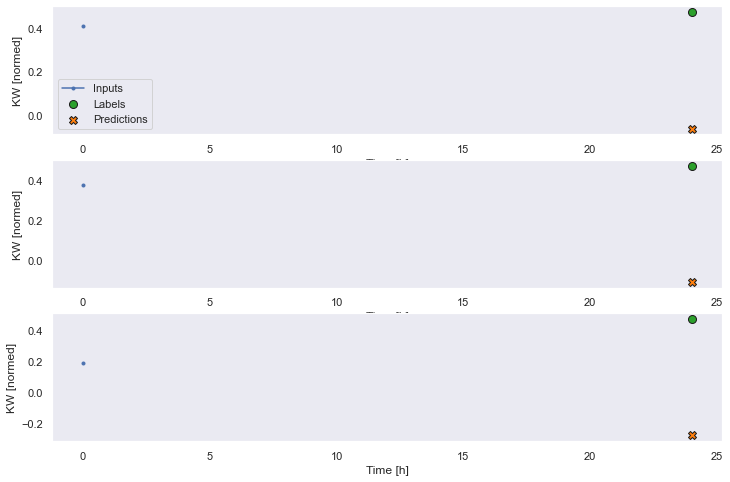

In [161]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

single_step_window.plot(dense)

#### Model 4: LSTM

In [162]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, single_step_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

#single_step_window.plot(lstm_model)

Epoch 1/100
184/184 [==============================] - 2s 4ms/step - loss: 0.5827 - mean_absolute_error: 0.6218 - val_loss: 0.5141 - val_mean_absolute_error: 0.5807
Epoch 2/100
184/184 [==============================] - 0s 3ms/step - loss: 0.4933 - mean_absolute_error: 0.5413 - val_loss: 0.4243 - val_mean_absolute_error: 0.5153
Epoch 3/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4887 - mean_absolute_error: 0.5353 - val_loss: 0.3986 - val_mean_absolute_error: 0.4942
Epoch 4/100
184/184 [==============================] - 1s 3ms/step - loss: 0.4864 - mean_absolute_error: 0.5326 - val_loss: 0.3895 - val_mean_absolute_error: 0.4860
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4846 - mean_absolute_error: 0.5310 - val_loss: 0.3855 - val_mean_absolute_error: 0.4822
Epoch 6/100
184/184 [==============================] - 0s 2ms/step - loss: 0.4830 - mean_absolute_error: 0.5297 - val_loss: 0.3832 - val_mean_absolute_error: 0.4799
Epoch 7/10

### Multip-step models
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions. The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape

Earlier we were using one data point to forecast energy prediction 24 hours into the future. Now we are using 24 datapoints (one day's data) to forecast energy consumption 
<br> Further reserch: should we use one day data - let's experiment with this
<br> but also: we can only get three hours into the future

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 24 hour into the future.')

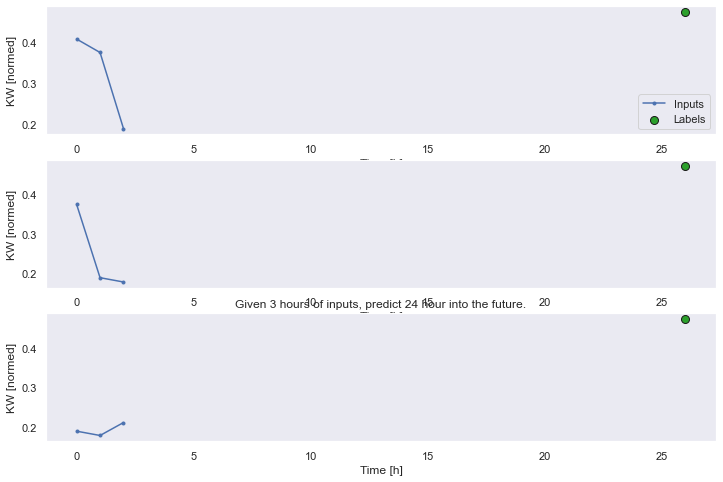

In [163]:
CONV_WIDTH = 3
shift = forecast_days*data_frequency_num_points
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=shift,
    label_columns=['KW'])

conv_window.plot()
plt.title(f"Given {CONV_WIDTH} hours of inputs, predict {shift} hour into the future.")

#### Model 5: Multi-step Dense

52/52 [==============================] - 0s 859us/step - loss: 0.3146 - mean_absolute_error: 0.4257


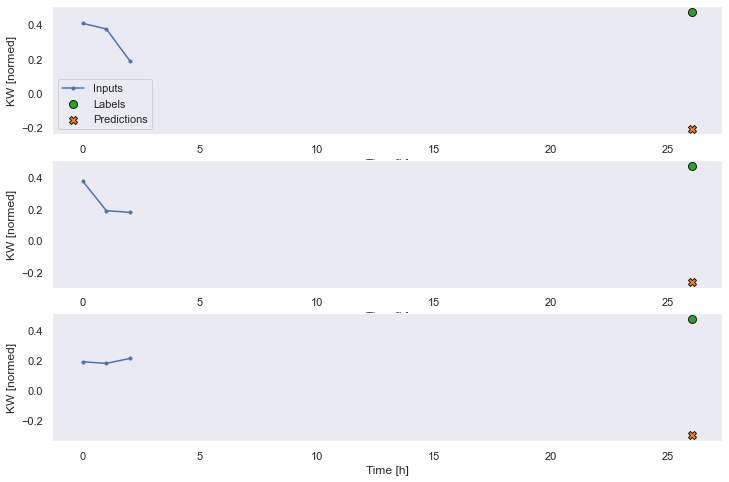

In [164]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

conv_window.plot(multi_step_dense)

#### Model 6: Multi-step CNN

52/52 [==============================] - 0s 904us/step - loss: 0.3173 - mean_absolute_error: 0.4274


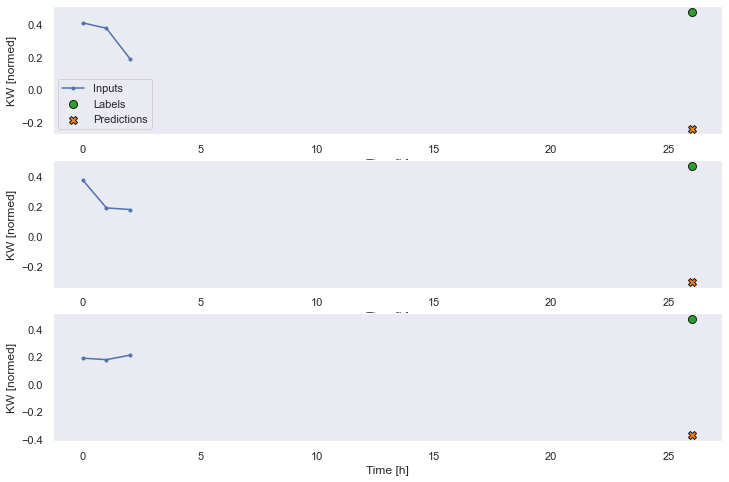

In [165]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Multi step Conv'] = conv_model.evaluate(conv_window.val)
performance['Multi step Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

conv_window.plot(conv_model)

Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


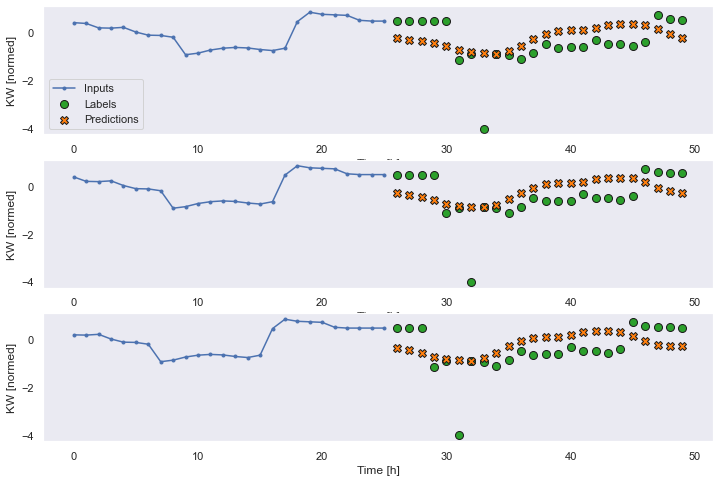

In [166]:
# to show more than one example at a time
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=shift,
    label_columns=['KW'])

print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

wide_conv_window.plot(conv_model)

#### Performance

Mean Absolute Error

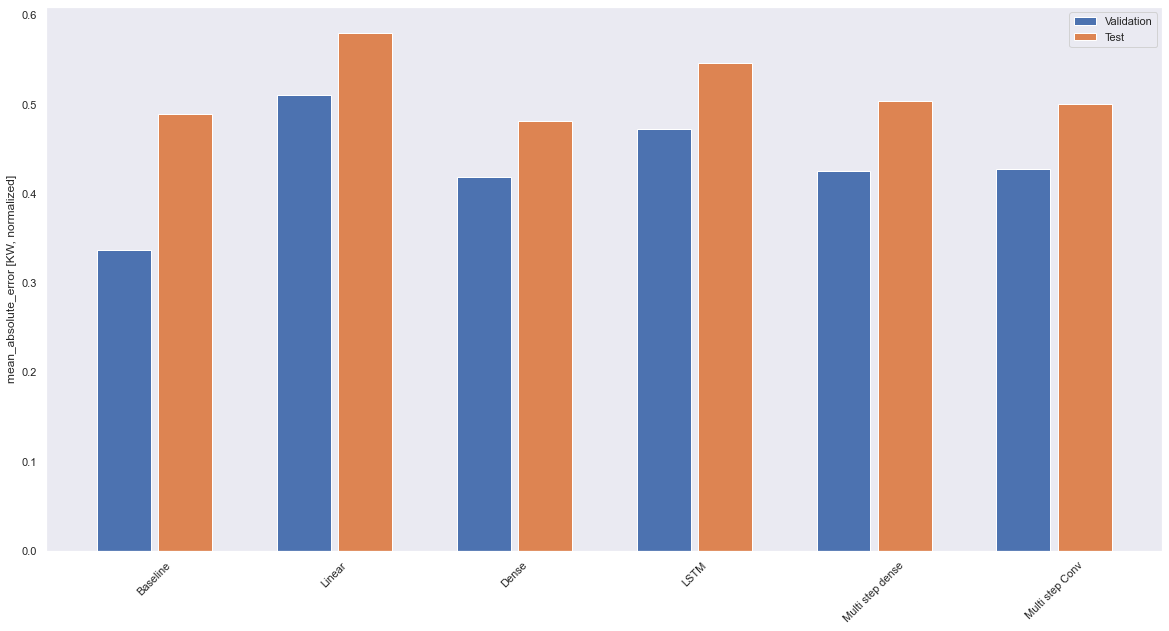

In [167]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [KW, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [168]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.4890
Linear      : 0.5802
Dense       : 0.4814
LSTM        : 0.5468
Multi step dense: 0.5044
Multi step Conv: 0.5007


#### Residual Analysis

Multi-step models

In [184]:
res_ms_model = conv_model
num_ms_predicted = len(res_ms_model.predict(conv_window.test))

In [185]:
residuals_df = pd.DataFrame(list(test_df.index)[-num_ms_predicted:], columns=['DATETIME'])
residuals_df['predicted_KW'] = res_ms_model.predict(conv_window.test, verbose=0).reshape(1, -1)[0]
residuals_df['actual_KW'] = list(test_df['KW'])[-num_ms_predicted:]
residuals_df['residuals'] = residuals_df['actual_KW'] - residuals_df['predicted_KW']
residuals_df.set_index('DATETIME', inplace=True)

Single-step models

In [118]:
res_ss_model = baseline
num_ss_predicted = len(res_ss_model.predict(single_step_window.test))

In [178]:
residuals_ss_df = pd.DataFrame(list(test_df.index)[-num_ss_predicted:], columns=['DATETIME'])
residuals_ss_df['predicted_KW'] = res_ss_model.predict(single_step_window.test, verbose=0)[:, 0].reshape(1, -1)[0]
residuals_ss_df['actual_KW'] = list(test_df['KW'])[-num_ss_predicted:]
residuals_ss_df['residuals'] = residuals_ss_df['actual_KW'] - residuals_ss_df['predicted_KW']
residuals_ss_df.set_index('DATETIME', inplace=True)

Sanity checks

In [188]:
test_df.shape, num_ms_predicted, num_ss_predicted

((845, 6), 819, 821)

In [174]:
test_df.head()

,TEMP_AIR,KW,Day sin,Day cos,Week sin,Week cos
DATETIME,,,,,,
2020-07-27 16:00:00,1.49,-0.91,-1.23,-7.08e-01,-1.23,-0.70
2020-07-27 17:00:00,1.07,-1.07,-1.37,-3.67e-01,-1.25,-0.65
2020-07-27 18:00:00,0.68,-0.91,-1.42,-1.03e-03,-1.28,-0.61
2020-07-27 19:00:00,0.39,-0.82,-1.37,3.65e-01,-1.30,-0.56
2020-07-27 20:00:00,0.34,-0.97,-1.23,7.06e-01,-1.32,-0.51


Plot test vs. prediction for single and multi step models

Text(0.5, 1.0, 'Mutli-step model Actual vs. Predicted KW')

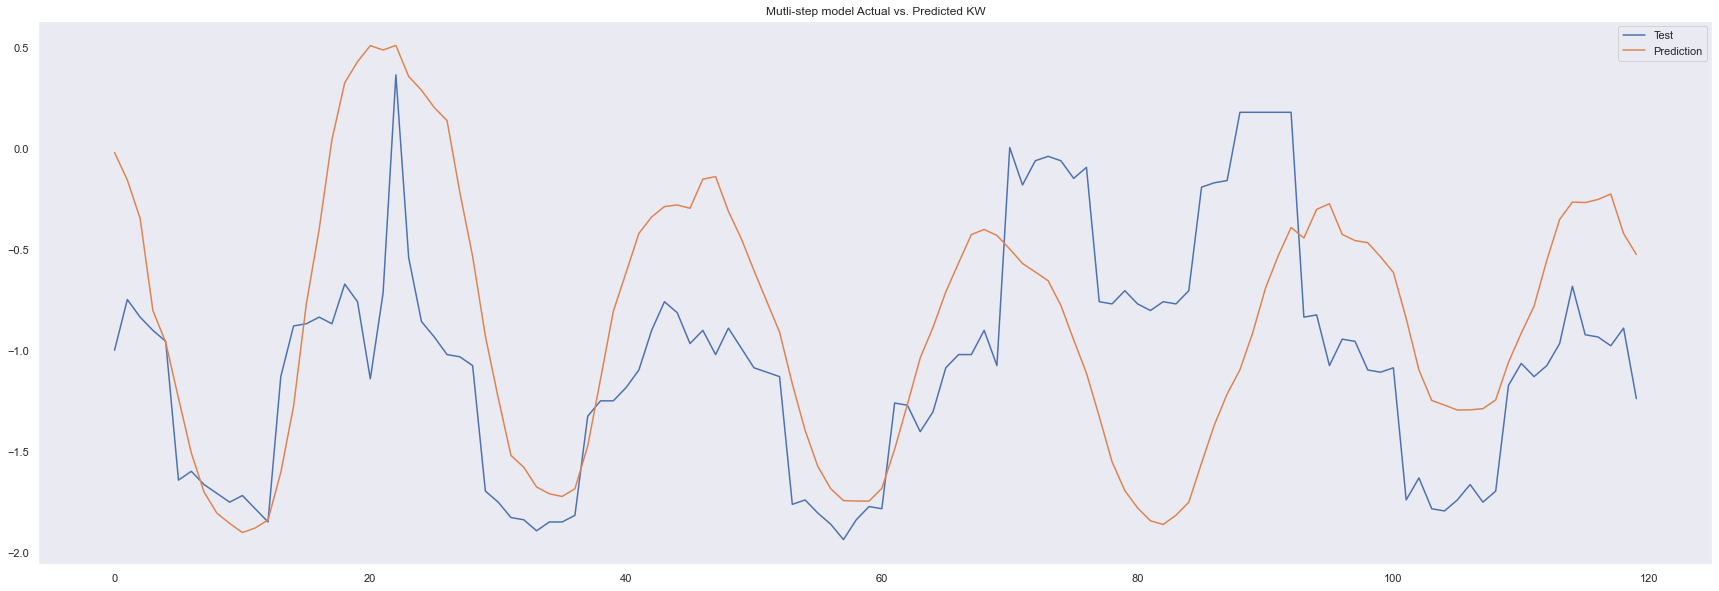

In [192]:
plt.figure(figsize=(30,10))
plt.plot(list(residuals_df['actual_KW'])[0:120], label="Test")
plt.plot(list(residuals_df['predicted_KW'])[0:120], label="Prediction")
#plt.plot(residuals_df['residuals'], label="residuals")
plt.legend(loc = 'best')
plt.title("Mutli-step model Actual vs. Predicted KW")

Text(0.5, 1.0, 'Correlation between Actual and Predicted KW')

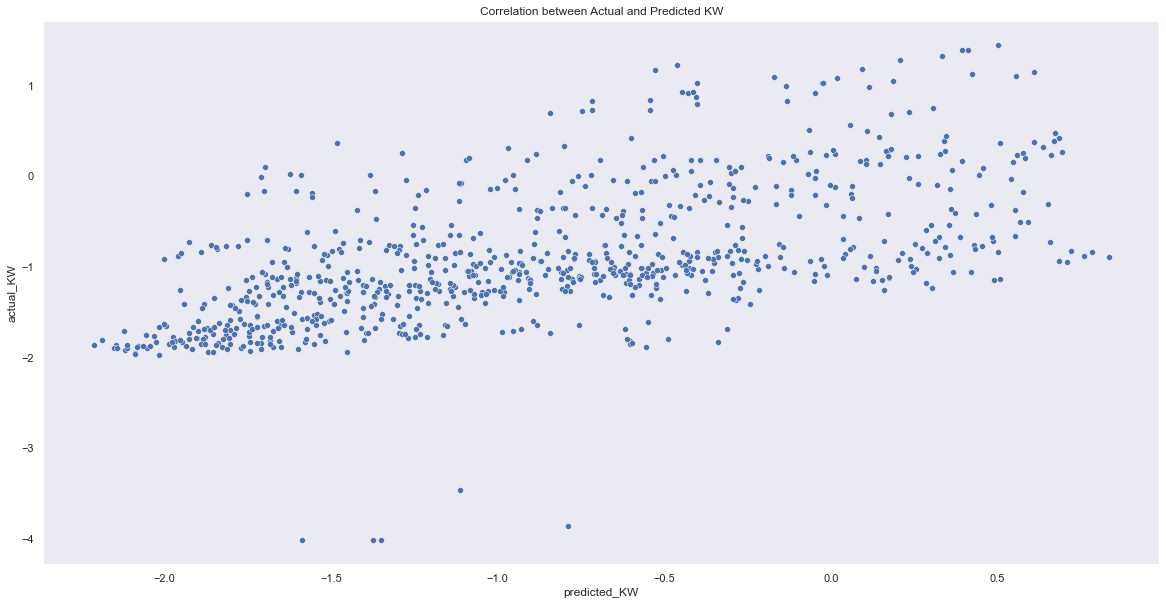

In [193]:
#correlation between predicted and actual KW
plot_size = (5, 5)
sns.scatterplot(x='predicted_KW', y='actual_KW', data=residuals_df)
plt.title("Correlation between Actual and Predicted KW")

Text(0.5, 1.0, 'Single-step model Actual vs. Predicted KW')

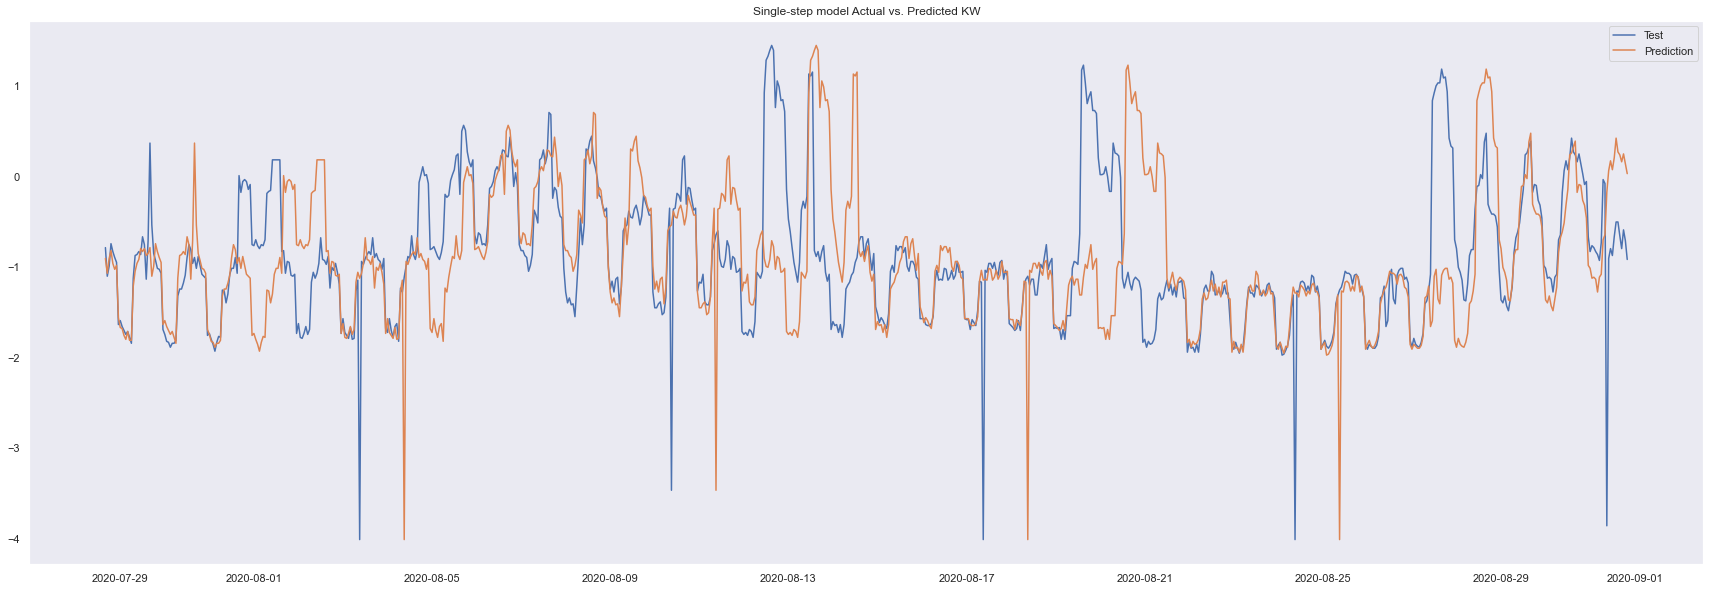

In [183]:
plt.figure(figsize=(30,10))
plt.plot(residuals_ss_df['actual_KW'],label="Test")
plt.plot(residuals_ss_df['predicted_KW'], label="Prediction")
#plt.plot(residuals_ss_df['residuals'], label="residuals")
plt.legend(loc = 'best')
plt.title("Single-step model Actual vs. Predicted KW")

Text(0.5, 1.0, 'Correlation between Actual and Predicted KW')

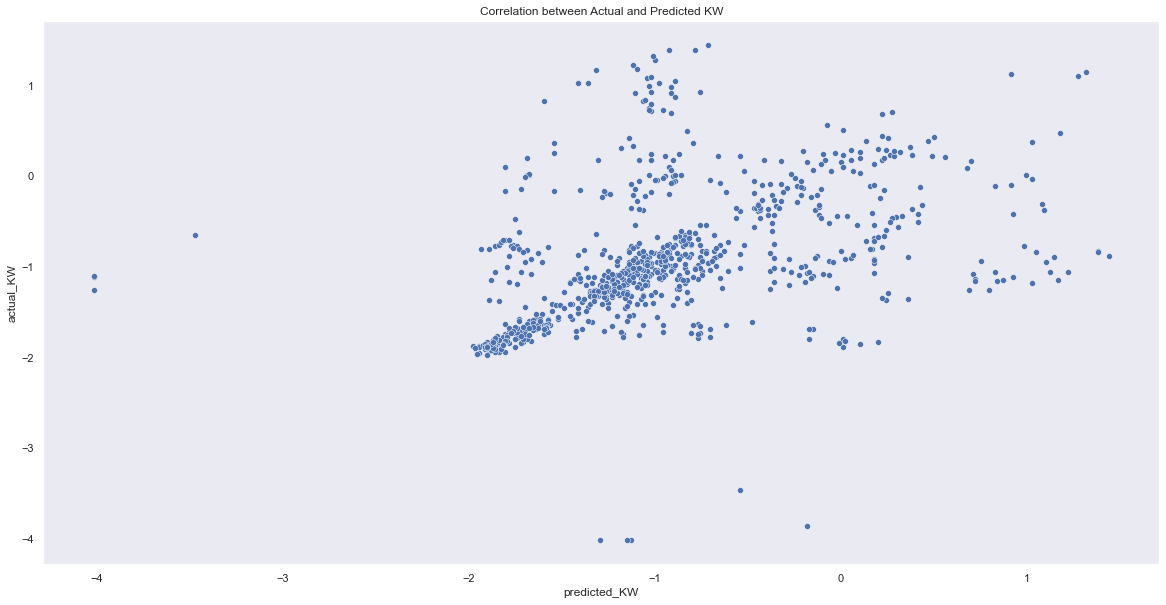

In [182]:
#correlation between predicted and actual KW
plot_size = (5, 5)
sns.scatterplot(x='predicted_KW', y='actual_KW', data=residuals_ss_df)
plt.title("Correlation between Actual and Predicted KW")